In [11]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'cs231n-project/daniel/'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n-project/daniel


In [12]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import tqdm.notebook as tq
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('seaborn')

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float
print(f'device: {device}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device: cpu


In [25]:
C = 2
BATCH_SIZE = 100
# NUM_TRAIN = 1250
# Only during dev:
NUM_TRAIN = 1000

def load_Fashion_MNIST():
  transform = T.Compose([T.ToTensor(), T.Normalize(mean=0.3139, std=0.3626)])
  train_dset = datasets.FashionMNIST('./datasets', train=True, download=True, transform=transform)
  test_dset = datasets.FashionMNIST('./datasets', train=False, download=True, transform=transform)
  
  # Get only first two classes
  train_dset.data = train_dset.data[train_dset.targets < C]
  train_dset.targets = train_dset.targets[train_dset.targets < C]
  test_dset.data = test_dset.data[test_dset.targets < C]
  test_dset.targets = test_dset.targets[test_dset.targets < C]

  ## Only on dev
  train_dset.data = train_dset.data[:NUM_TRAIN]
  train_dset.targets = train_dset.targets[:NUM_TRAIN]

  return train_dset, test_dset

train_dset, test_dset = load_Fashion_MNIST()
print(train_dset.data.shape, train_dset.targets.shape)
print(test_dset.data.shape, test_dset.targets.shape)

def get_loaders():
  train_loader = DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=False)
  test_loader = DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False)
  return train_loader, test_loader

train_loader, test_loader = get_loaders()

torch.Size([1000, 28, 28]) torch.Size([1000])
torch.Size([2000, 28, 28]) torch.Size([2000])


In [26]:
def check_accuracy(loader, model, loss_fn):  
    num_correct, num_samples = 0, 0
    model.eval()
    loss = 0.0
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(X).squeeze()
            loss += loss_fn(scores, y, model, scale_for_SGD=False)
            preds = (scores > 0.5).long()
            num_correct += (preds == y).sum()
            num_samples += preds.shape[0]
    acc = float(num_correct) / num_samples
    return acc, loss, num_correct, num_samples

def print_stats(iteration, loss, accuracy, num_correct, num_samples, dset):
  print('It: %d, %s | loss: %.3f, acc: %.2f%%, ratio: %d/%d' % (iteration, dset,  loss, 100 * accuracy, num_correct, num_samples))

def train(model, loss_fn, optimizer, train_loader, epochs, check_every, acc_check_loader_train, acc_check_loader_test, verbose):
  train_loss_history = []
  train_accuracy_history = []
  test_loss_history = []
  test_accuracy_history = []
  times = []
  start = time()
  done = False
  for e in tq.tqdm(range(epochs)):
    if done:
      break
    if verbose: 
      print(f'### Epoch {e} ###')
    for t, (X, y) in enumerate(train_loader):
      model.train()
      scores = model(X)

      # Forward pass
      loss = loss_fn(scores, y, model, scale_for_SGD=True)
      
      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if check_every is not None and (e*epochs + t) % check_every == 0:
        train_accuracy, train_loss, train_num_correct, train_num_samples = check_accuracy(acc_check_loader_train, model, loss_fn)
        test_accuracy, test_loss, test_num_correct, test_num_samples = check_accuracy(acc_check_loader_test, model, loss_fn)
        times.append(time() - start)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)
        if verbose:
          print_stats((e*epochs + t), train_loss, train_accuracy, train_num_correct, train_num_samples, 'train')
          print_stats((e*epochs + t), test_loss, test_accuracy, test_num_correct, test_num_samples, 'test')
        if train_accuracy == 1.0:
          done = True
          break
  
  return train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history, times

In [27]:
class Polly(nn.Module):
  def forward(self, x):
    return (0.09 * x**2 + 0.5 * x + 0.47)

class Conv2dUnitNorm(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super(Conv2dUnitNorm, self).__init__()
    self.Conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)

  def forward(self, x):
    W = self.Conv2d.weight                               # (C_out, 1, F, F)
    C_out = W.shape[0]
    norm = torch.linalg.norm(W.view((C_out, -1)), dim=1) # (C_out, )
    norm = norm.reshape((1, C_out, 1, 1)) # reshape for broadcast
    out = self.Conv2d(x) / norm           # (N, C_out, new_width, new_height)
    return out

H = 64
beta = 10**(-6)

model = nn.Sequential(
  Conv2dUnitNorm(in_channels=1, out_channels=H, kernel_size=4, stride=4, padding=0),
  Polly(),
  nn.Flatten(),
  nn.Linear(H * 7 * 7, 1, bias=False)
)

def loss_fn(scores, y, model, scale_for_SGD):
  N = scores.shape[0]
  W2 = model[3].weight
  if scale_for_SGD:
    loss = 0.5*((scores.squeeze() - y)**2).sum() * NUM_TRAIN/N + beta * torch.abs(W2).sum()
  else:
    loss = 0.5*((scores.squeeze() - y)**2).sum() + beta * torch.abs(W2).sum() * N/NUM_TRAIN
  return loss


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=10**(-9), momentum=0.9)
train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history, times = train(
    model, loss_fn, optimizer, train_loader, epochs=150,
    check_every=10, acc_check_loader_train=train_loader, acc_check_loader_test=test_loader, verbose=True,
)


### Epoch 0 ###
It: 0, train | loss: 300.190, acc: 40.10%, ratio: 401/1000
It: 0, test | loss: 558.562, acc: 44.65%, ratio: 893/2000
### Epoch 1 ###
It: 150, train | loss: 109.887, acc: 64.40%, ratio: 644/1000
It: 150, test | loss: 230.222, acc: 62.65%, ratio: 1253/2000
### Epoch 2 ###
It: 300, train | loss: 47.193, acc: 92.90%, ratio: 929/1000
It: 300, test | loss: 92.120, acc: 93.70%, ratio: 1874/2000
### Epoch 3 ###
It: 450, train | loss: 35.954, acc: 92.00%, ratio: 920/1000
It: 450, test | loss: 73.720, acc: 92.05%, ratio: 1841/2000
### Epoch 4 ###
It: 600, train | loss: 32.921, acc: 95.40%, ratio: 954/1000
It: 600, test | loss: 67.189, acc: 95.65%, ratio: 1913/2000
### Epoch 5 ###
It: 750, train | loss: 29.510, acc: 95.30%, ratio: 953/1000
It: 750, test | loss: 60.143, acc: 95.90%, ratio: 1918/2000
### Epoch 6 ###
It: 900, train | loss: 27.409, acc: 96.10%, ratio: 961/1000
It: 900, test | loss: 55.891, acc: 96.40%, ratio: 1928/2000
### Epoch 7 ###
It: 1050, train | loss: 26.420, a

In [16]:
# np.save(f'./experiments/CNN_FashionMNIST_NonConvex_optim_{"Adam"}_lr_{1e-4}_epochs_{400}_{"training"}_{"loss_history"}.npy', train_loss_history)
# np.save(f'./experiments/CNN_FashionMNIST_NonConvex_optim_{"Adam"}_lr_{1e-4}_epochs_{400}_{"training"}_{"accuracy_history"}.npy', train_accuracy_history)
# np.save(f'./experiments/CNN_FashionMNIST_NonConvex_optim_{"Adam"}_lr_{1e-4}_epochs_{400}_{"test"}_{"loss_history"}.npy', test_loss_history)
# np.save(f'./experiments/CNN_FashionMNIST_NonConvex_optim_{"Adam"}_lr_{1e-4}_epochs_{400}_{"test"}_{"accuracy_history"}.npy', test_accuracy_history)
# np.save(f'./experiments/CNN_FashionMNIST_NonConvex_optim_{"Adam"}_lr_{1e-4}_epochs_{400}_{""}_{"times"}.npy', times)

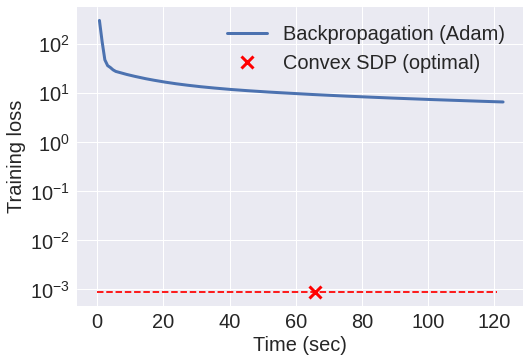

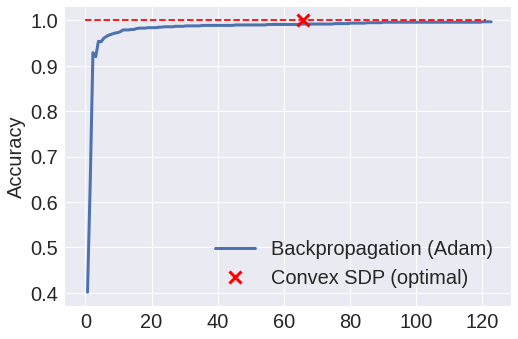

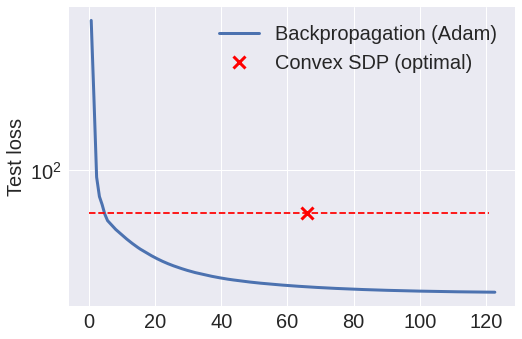

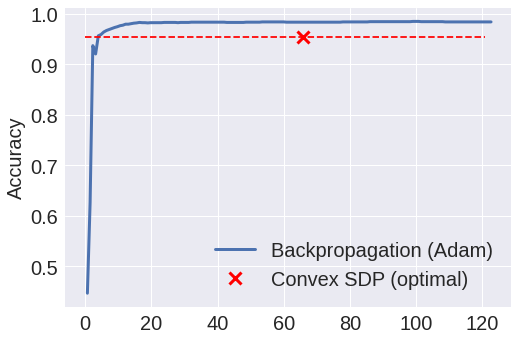

In [28]:
# train_loss_history = np.load(f'./experiments/CNN_FashionMNIST_NonConvex_optim_{"Adam"}_lr_{1e-4}_epochs_{400}_{"training"}_{"loss_history"}.npy')
# train_accuracy_history = np.load(f'./experiments/CNN_FashionMNIST_NonConvex_optim_{"Adam"}_lr_{1e-4}_epochs_{400}_{"training"}_{"accuracy_history"}.npy')
# test_loss_history = np.load(f'./experiments/CNN_FashionMNIST_NonConvex_optim_{"Adam"}_lr_{1e-4}_epochs_{400}_{"test"}_{"loss_history"}.npy')
# test_accuracy_history = np.load(f'./experiments/CNN_FashionMNIST_NonConvex_optim_{"Adam"}_lr_{1e-4}_epochs_{400}_{"test"}_{"accuracy_history"}.npy')
# times = np.load(f'./experiments/CNN_FashionMNIST_NonConvex_optim_{"Adam"}_lr_{1e-4}_epochs_{400}_{""}_{"times"}.npy')

convex_time = 65.877
convex_train_loss = 0.0008672259147097226
convex_train_accuracy = 1.0
convex_test_loss = 61.3037
convex_test_accuracy = 0.954

max_timerange = int(max(max(times), convex_time))
timerange = list(range(max_timerange))

plt.rcParams.update({'font.size': 40})
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.xlabel('Time (sec)')

plt.semilogy(times, train_loss_history, linewidth=3, label='Backpropagation (Adam)')
plt.ylabel(r'Training loss')
plt.plot(timerange,[convex_train_loss]*max_timerange, "--", color='r')
plt.plot(convex_time, convex_train_loss, 'rx', linewidth=3, markersize=12, markeredgewidth=3, label="Convex SDP (optimal)")
plt.legend()
# plt.savefig(f'./plots/CNN_NoPooling_FashionMNIST_{"training"}_{"loss"}')
plt.show()

plt.plot(times, train_accuracy_history, linewidth=3, label='Backpropagation (Adam)')
plt.ylabel('Accuracy')
plt.plot(timerange,[convex_train_accuracy]*max_timerange, "--", color='r')
plt.plot(convex_time, convex_train_accuracy, 'rx', linewidth=3, markersize=12, markeredgewidth=3, label="Convex SDP (optimal)")
plt.legend()
# plt.savefig(f'./plots/CNN_NoPooling_FashionMNIST_{"training"}_{"accuracy"}')
plt.show()


plt.semilogy(times, test_loss_history, linewidth=3, label='Backpropagation (Adam)')
plt.ylabel(r'Test loss')
plt.plot(timerange,[convex_test_loss]*max_timerange, "--", color='r')
plt.plot(convex_time, convex_test_loss, 'rx', linewidth=3, markersize=12, markeredgewidth=3, label="Convex SDP (optimal)")
plt.legend()
# plt.savefig(f'./plots/CNN_NoPooling_FashionMNIST_{"test"}_{"loss"}')
plt.show()

plt.plot(times, test_accuracy_history, linewidth=3, label='Backpropagation (Adam)')
plt.ylabel('Accuracy')
plt.plot(timerange,[convex_test_accuracy]*max_timerange, "--", color='r')
plt.plot(convex_time, convex_test_accuracy, 'rx', linewidth=3, markersize=12, markeredgewidth=3, label="Convex SDP (optimal)")
plt.legend()
# plt.savefig(f'./plots/CNN_NoPooling_FashionMNIST_{"test"}_{"accuracy"}')
plt.show()